### 1 - Objetivo
O seguinte trabalho tem por objetivo a criação de uma inteligência artificial que consiga diferenciar uma floresta desmatada de uma floresta normal.


### 2 - Esclarecimento
Esse trabalho foi produzido seguindo os ensinamentos do curso  <a href="https://course.fast.ai/">Pratical Deep Learning for Coders</a>.

### 3 - Motivação
Há muito tempo se discute a importância do combate ao desmatamento para evitar o acarretamento de diversos problemas ambientais, tal como o agravamento das mudanças climáticas, perda de biodiversidade, erosão do solo e entre outros.
Dito isso, para auxiliar empresas ou órgãos públicos competentes, o presente trabalho visa contribuir com o reconhecimento de imagens que possuem desmatamento, através da utilização de um modelo treinado para tal.

### 4 - Instalação
Para realizar a configuração do ambiente que rodará o projeto é necessário a instalação das seguintes tecnologias:
- <a href="https://www.python.org/download/releases/3.0/">Python3</a>
- <a href="https://code.visualstudio.com/">Visual Studio Code</a>
- <a href="https://pypi.org/project/pip/">Pip</a>

Extensões para o Visual Studio Code
- Jupyter
- Jupyter Keymap
- Jupyter Cell Tags

Rode o seguinte comando pip para fazer a instalação ou o upgrade da última versão do fastai e duckduckgo_search:

In [1]:
!pip install -Uqq fastai duckduckgo_search

### 5 - Criação do Projeto

Para a criação do projeto iremos começar definindo uma função que retornará links de imagens encontradas pela pesquisa de um determinado termo no Duck Duck Go.

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=60):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Utilizando a função acima em conjunto com a função "download_images", nesse passo iremos baixar 30 imagens de cada uma das seguintes pesquisas: "deforested forest" e "forest". Essas imagens serão usadas para treinar nosso modelo.

In [3]:
from fastai.vision.all import *
searches = 'deforested forest','forest'
path = Path('forest_deforestation_identify')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

/home/valdersonjr/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/valdersonjr/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Searching for 'deforested forest photo'
Searching for 'forest photo'


Seguindo o exemplo do <a href="https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data"> Is it a bird? Creating a model from your own data </a> demonstrado no curso, a próxima linha de código irá remover imagens baixadas incorretamente e que não servirão de exemplo para treinar nosso modelo.

In [4]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

O conjunto de código seguinte é um DataLoader (objeto que contém as imagens a serem usadas para treinar o modelo). O DataLoader a seguir será criado usando DataBlock.

blocks=(ImageBlock, CategoryBlock): as entradas (imagens ou "ImageBlock") serão subdivididas em categorias (ou "CategoryBlock").

get_items=get_image_files: irá retornar uma lista de todas as imagens em um caminho/diretório.

splitter=RandomSplitter(valid_pct=0.2, seed=42): irá pegar 20% (valid_pct=0.2) dos dados para servirem como base para validar o modelo.

get_y=parent_label: irá rotular cada imagem com o nome de seu "pai". Exemplo: "forest".

item_tfms=[Resize(192, method='squish')]: irá "esmagar" as imagens para caberem em 192x192 pixels.



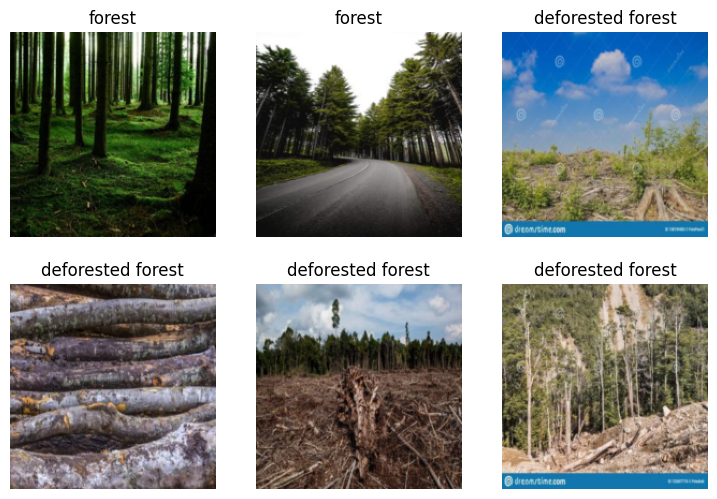

In [5]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=60)

dls.show_batch(max_n=10)

Com tudo pronto, agora iremos treinar o modelo. Para tal, o fastai providencia o "fine_tune", que é um método que usa automaticamente as melhores práticas para o aprimoramento de um modelo pré treinado.

In [14]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/valdersonjr/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/valdersonjr/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.879223,0.134035,0.063492,00:43


epoch,train_loss,valid_loss,error_rate,time


Tendo o modelo treinado, vamos irei baixar duas imagens (uma com desmatamento e outra sem) para realizar o teste.

Searching for 'forest photo'


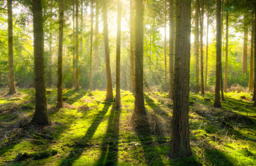

In [7]:
from fastdownload import download_url

download_url(search_images('forest photo', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Searching for 'forest deforestation photo'


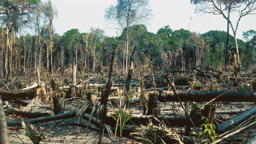

In [8]:
download_url(search_images('forest deforestation photo', max_images=1)[0], 'deforestation.jpg', show_progress=False)
Image.open('deforestation.jpg').to_thumb(256,256)

### 6 - Usando o modelo

In [13]:
is_deforestation,_,probs = learn.predict(PILImage.create('deforestation.jpg'))
print(f"This is a: {is_deforestation}.")
print(f"Probability it is deforestation: {probs[0]:.4f}")

This is a: deforested forest.
Probability it is deforestation: 0.9981
